In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import sqrt

import DataAid
import DataImporter
import Neros

In [6]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
littleDataGalaxies = DataAid.GetGalaxyData("data/little-data-things/data/")
lcmGalaxies = DataAid.GetGalaxyData("data/LCMFits/data/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
mcGaughMW = DataAid.GetGalaxyData("data/McGaugh/")
# Get the galaxies we want from each source
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])
MWMcGaugh = np.array(mcGaughMW['MW_lumMcGaugh'])

# chi squared function
def chiSquared(observed, expected, error):
    chiSquared = 0
    
    for i in range(len(observed)):
        chiSquared = chiSquared + (((observed[i] - expected[i])**2) / (error[i]**2))
        
    return chiSquared / len(observed)

# Fit function
def simple(independents, alpha, vDiskFreeParam, vBulgeFreeParam):

    # Parse out data for the galaxy
    rad, vGas, vDisk, vBulge = independents
    # Apply the vLum free param to the data
    #vLum = vLum*vLumFreeParam
    #vGas = vGas*vGasFreeParam
    vBulge = vBulge*vBulgeFreeParam
    vDisk = vGas*vDiskFreeParam
    vLum = np.sqrt(Neros.vLumSquared(vGas,vDisk,vBulge))
    # Calc vLCM with alpha free param
    vLcm = Neros.vLcm(rad, MW_vLum_interp_func(rad), vLum)
    # Calc and return vNeros
    return Neros.vNeros(vLum, vLcm, alpha)

## Create the Milky Way interpolation function

In [7]:
MW_rad_XueSofue = MWXueSofue[:,0]
MW_vLum_XueSofue = MWXueSofue[:,1]
MW_rad_McGaugh = MWMcGaugh[:,0]
MW_vLum_McGaugh = MWMcGaugh[:,1]

# Change these to change MW model used for fitting
#MW_rad = MW_rad_McGaugh
#MW_vLum = MW_vLum_McGaugh
MW_rad = MW_rad_XueSofue
MW_vLum = MW_vLum_XueSofue

# this variable is used include MW model in fit data csv and graph png name 
# so we know which one we used to make the fit
#MW_name = "MWMcGaugh"
MW_name = "MWXueSofue"
# Interpolation function
MW_vLum_interp_func = interp1d(MW_rad, MW_vLum, kind='cubic')

## Running VNeros on every galaxy
We calculate vNeros for each galaxy and then plot the ratio between vNeros and the galaxy's vObs

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


galaxyName is: NGC5371_rotmod
chiSquare is: 985.0547437070701
fittedAlpha is: -9034.313068060243, 
fittedVLumFreeParamsare: (1.0, 5.616056073658521)
--------------------------
galaxyName is: UGC07603_rotmod
chiSquare is: 15.113503120961868
fittedAlpha is: 6237.930921987092, 
fittedVLumFreeParamsare: (1.0, 2.5964288539250755)
--------------------------


/Users/sophiacisneros/Desktop/RCFM_Gen/RCFM/Neros.py:91: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.square(vLum) + (vLcm*fittedAlpha) )


galaxyName is: NGC4138_rotmod
chiSquare is: 7.7626629666969915
fittedAlpha is: -2054.9724916101245, 
fittedVLumFreeParamsare: (0.9917214173687392, 9.568177347640836)
--------------------------
galaxyName is: UGC12632_rotmod
chiSquare is: 36.78625894424885
fittedAlpha is: 6619.191413011397, 
fittedVLumFreeParamsare: (1.0, 2.1509028995412804)
--------------------------
galaxyName is: NGC5033_rotmod
chiSquare is: 42.94643899664723
fittedAlpha is: 198.47100528561614, 
fittedVLumFreeParamsare: (1.0111057494637834, 1.6725773743983794)
--------------------------
galaxyName is: UGC02023_rotmod
chiSquare is: 0.5386294860328436
fittedAlpha is: 1689.0583342106738, 
fittedVLumFreeParamsare: (1.0, 2.7368211306249273)
--------------------------


ValueError: operands could not be broadcast together with shapes (68,) (53,) 

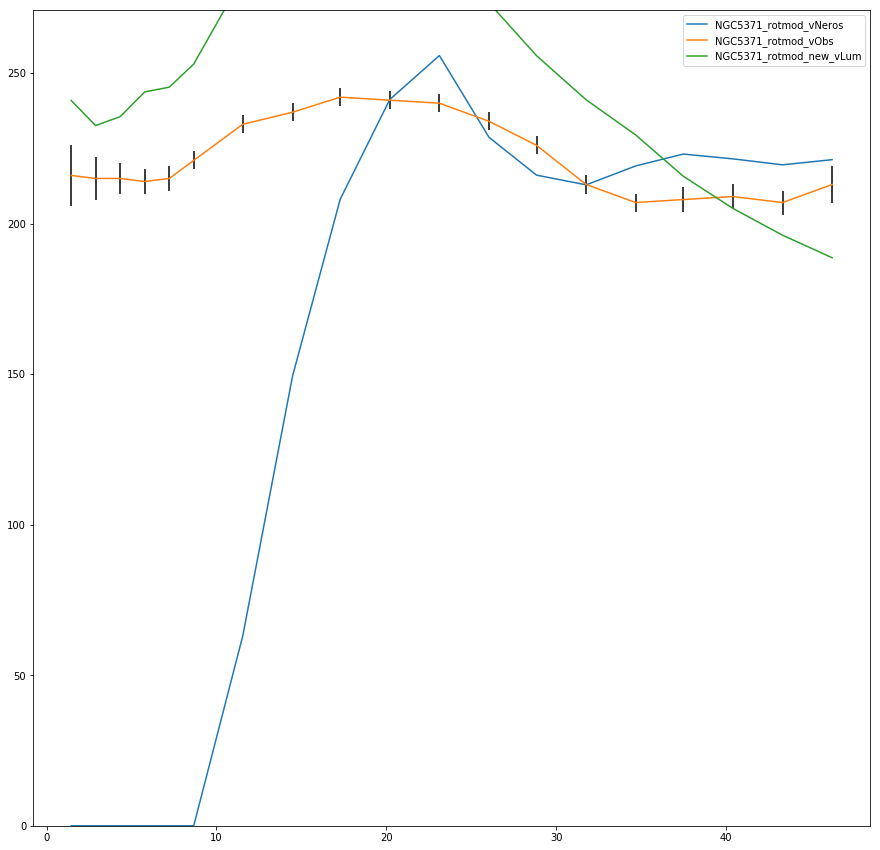

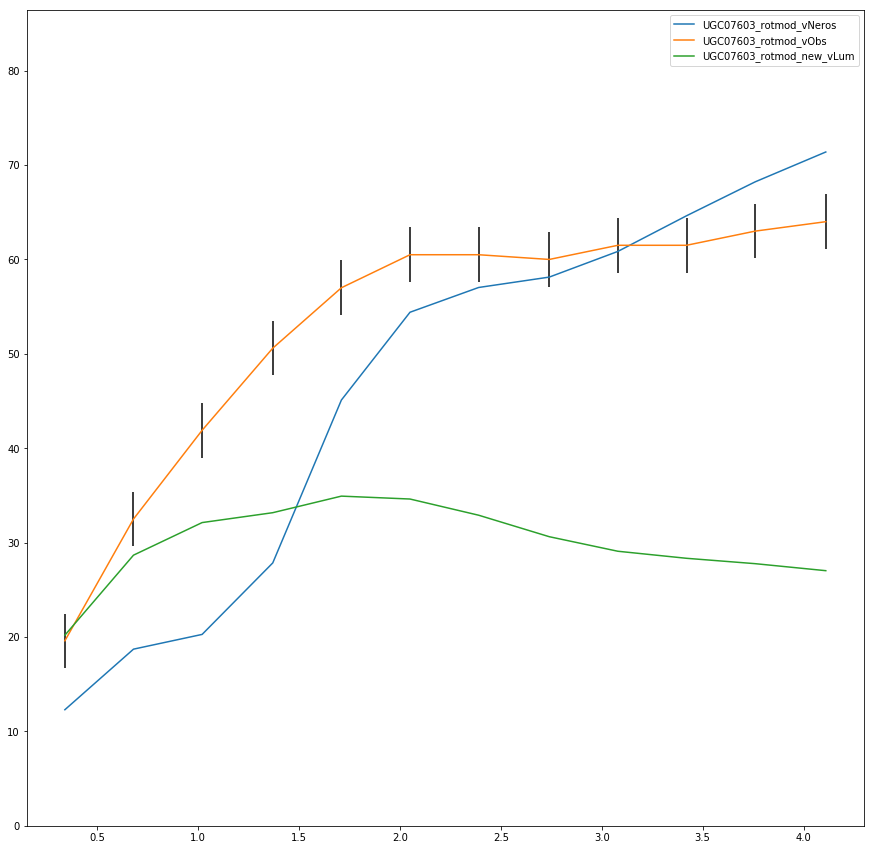

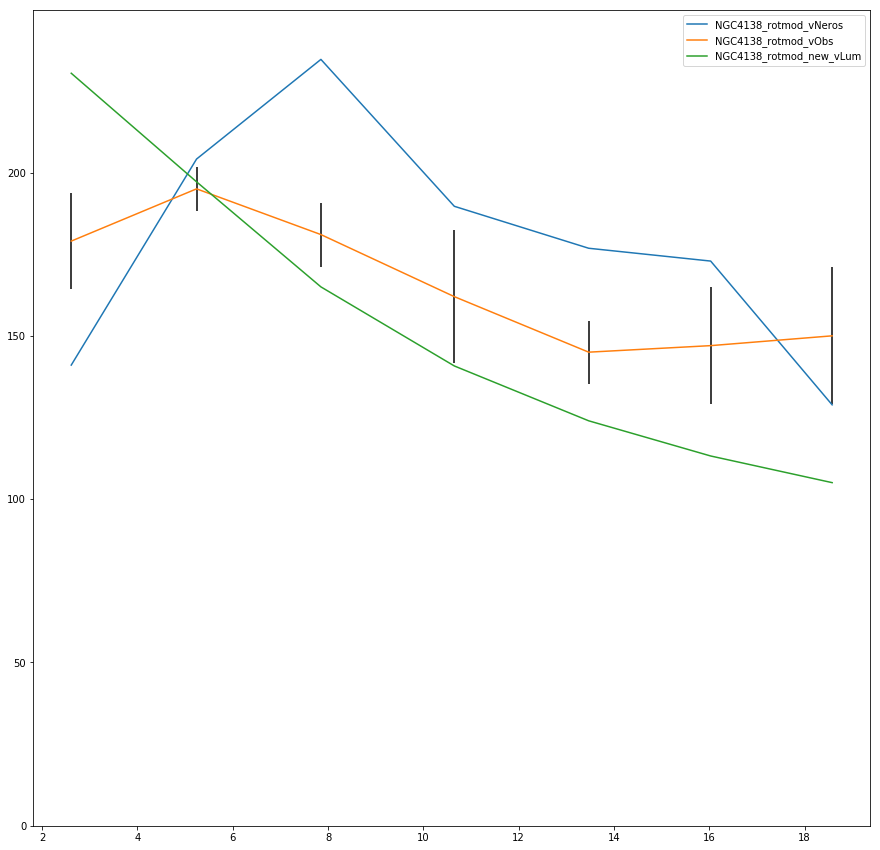

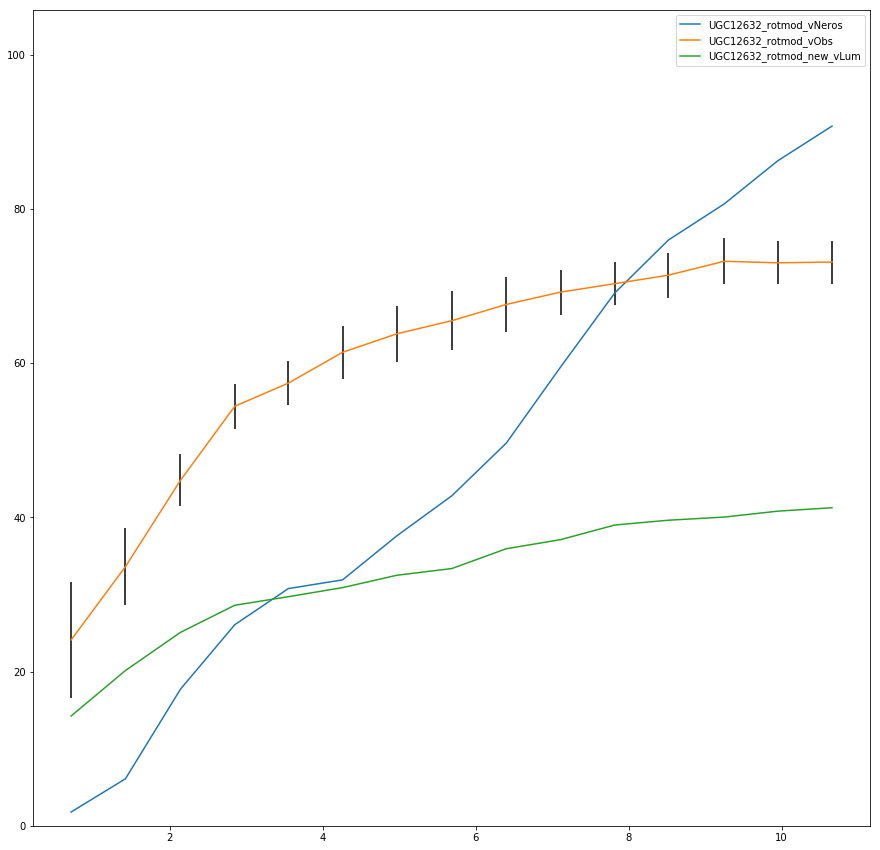

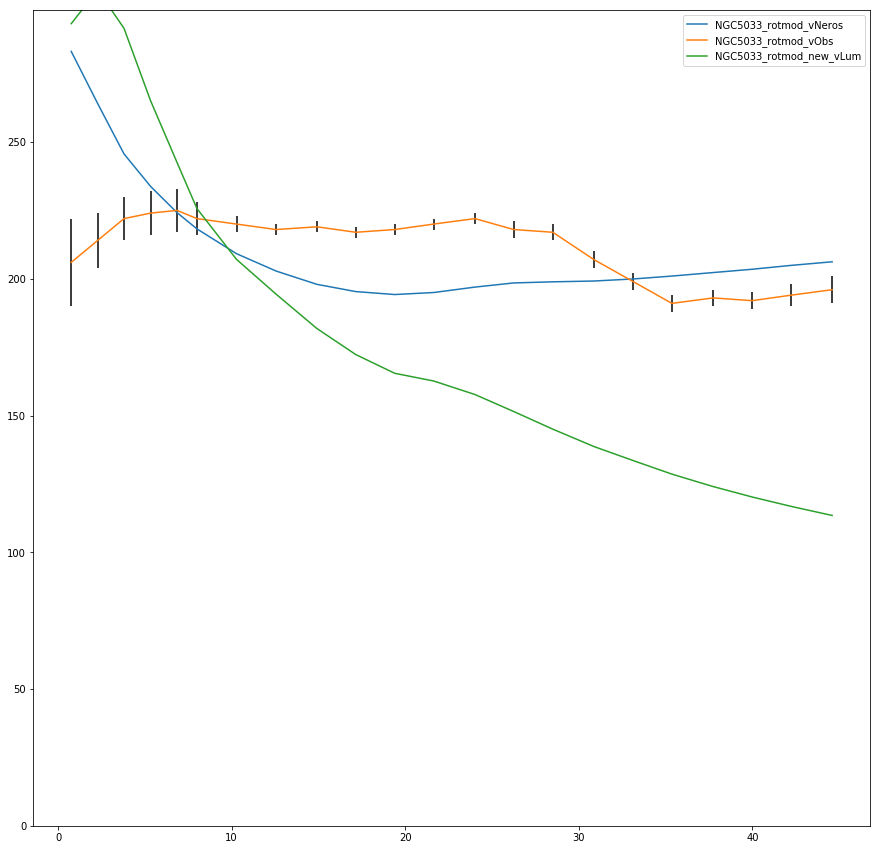

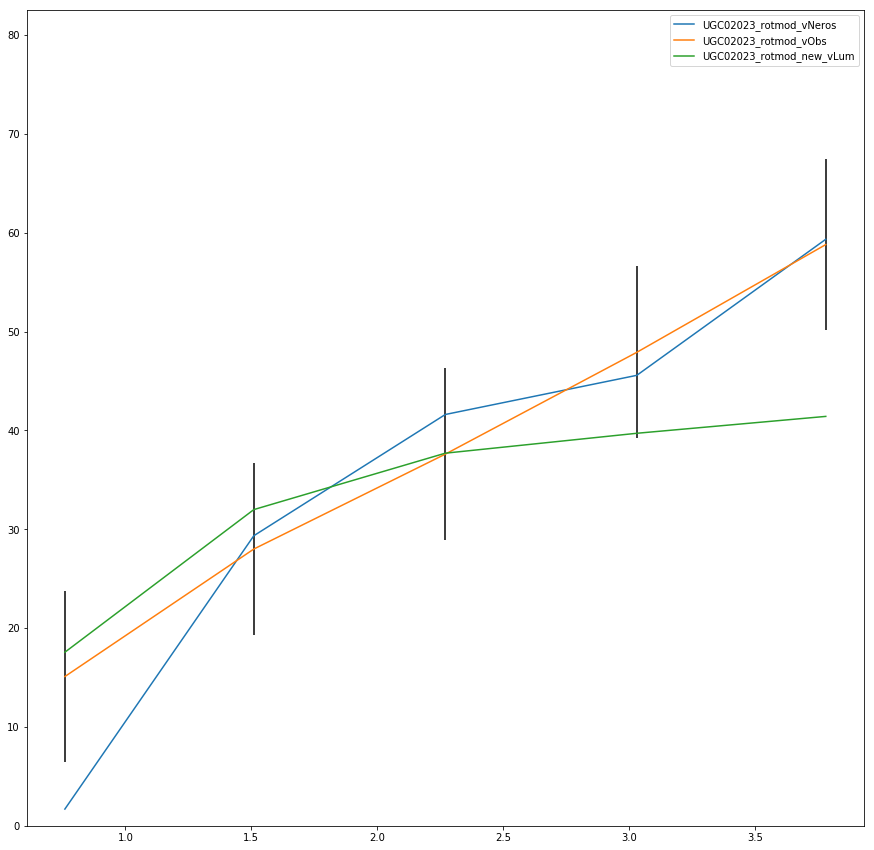

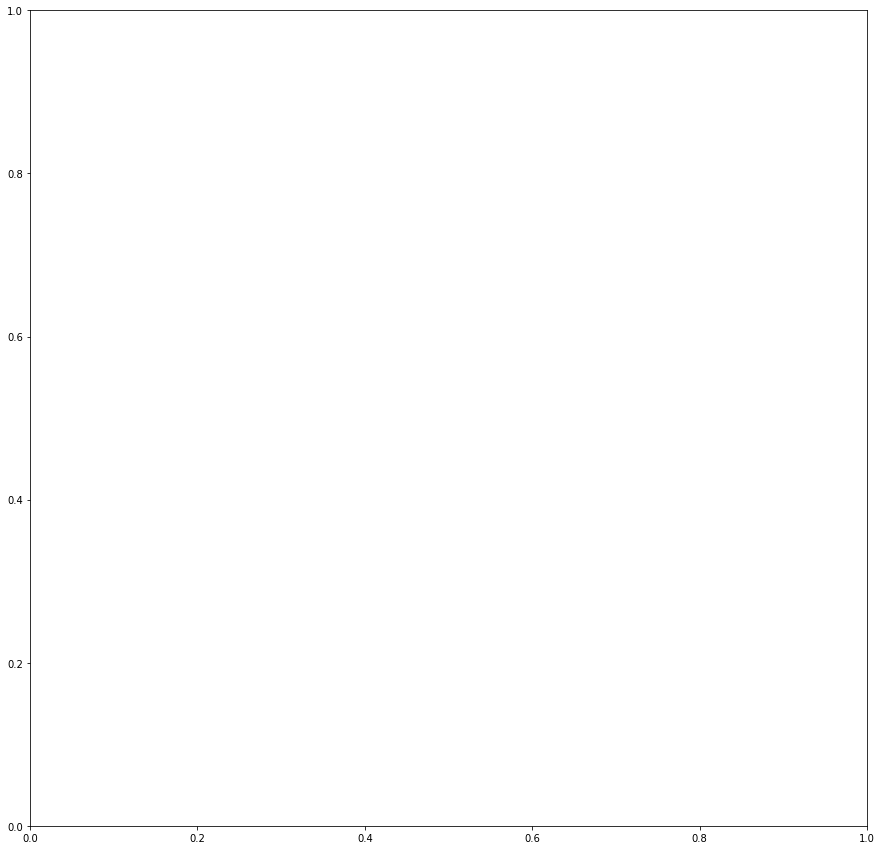

In [8]:
# This is where the fitted alpha & vlum free parameter will be written for each galaxy
out_file = "imported-data/data_" + str(MW_name) + ".csv"
with open(out_file, 'w') as f:
    f.write('{0},{1},{2},{3}\n'.format("Galaxy", "Chisquare","Alpha", "Beta"))
f.close()

vLcmList = []

avgChiSquared = 0.0
avgPhiZero = 0.0

# Change this and uncomment if statement below if just one galaxy is desired.
galaxyWeWant = ""

for galaxyName in sparcGalaxies:
    # Uncomment the following two lines to produce data and graphs for just galaxyWeWant
    #if (galaxyName != galaxyWeWant):
     # continue
    
    # data on this galaxy
    f, ax = plt.subplots(1, figsize = (15, 15))
    galaxy = np.array(sparcGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break
    
    # fitter
    vals, cov = curve_fit(simple,(galaxy_rad, galaxy_gas, galaxy_disk, galaxy_bulge),galaxy_vObs)
    fittedAlpha, fittedvDiskFreeParam, fittedvBulgeFreeParam = vals
    
    # Run vLCM
    vLcm = Neros.vLcm(galaxy_rad, MW_vLum_interp_func(galaxy_rad), galaxy_vLum)
    vLcmList.append(vLcm)
    vNeros = simple((galaxy_rad, galaxy_gas, galaxy_disk, galaxy_bulge), fittedAlpha, fittedvDiskFreeParam, fittedvBulgeFreeParam)
    #ratio = vNeros/galaxy_vObs
    
    # printing to file & console
    chiSquare = chiSquared(galaxy_vObs, vNeros, galaxy_error)
    avgChiSquared = avgChiSquared + chiSquare
    print(f"galaxyName is: {galaxyName}")
    
    print(f"chiSquare is: {chiSquare}")
    
    print(f"fittedAlpha is: {fittedAlpha}, \nfittedVLumFreeParamsare: {fittedvBulgeFreeParam, fittedvDiskFreeParam}")
    
   # print(f"beta is: {beta}")
    #print(f"MW_Phi is: {Neros.phi(galaxy_rad, MW_vLum_interp_func(galaxy_rad))}")
    
    #print(f"Other_Phi is: {Neros.phi(galaxy_rad, galaxy_vLum)}")
    
    print("--------------------------")
    
    # Write galaxyName, fittedAlpha, fittedVLumFreeParam to file
    with open(out_file, 'a') as f:
        f.write('{0},{1},{2},{3}\n'.format(galaxyName, chiSquare, fittedAlpha, fittedvBulgeFreeParam, fittedvDiskFreeParam))
    f.close()
    
    # Calculate galaxy_vObs plus error and put into list
    galaxy_vObs_err_incl = []
    for i in range(len(galaxy_vObs)):
        galaxy_vObs_err_incl.append(galaxy_vObs[i] + galaxy_error[i])
        
    # calculate new vLum
    galaxy_vLum_updated = []
    for i in range(len(galaxy_vLum)):
        galaxy_vLum_updated.append(galaxy_vLum[i])
        
    # plot
    # y-axis scales to the maximum velocity value in the list galaxy_vObs_err_incl
    # or to the maximum value in the list vNeros, whichever is the bigger number
    y_max = max(max(galaxy_vObs_err_incl), max(vNeros))
    ax.set_ylim(bottom = 0, top = y_max + 15)
    
    # plot vObs and vNeros and updated vLum
    ax.plot(galaxy_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vObs, label="{}_vObs".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vLum_updated, label="{}_new_vLum".format(galaxyName))
    
    # error bar in vObs
    for i in range(len(galaxy_rad)):
        ax.vlines(galaxy_rad[i], galaxy_vObs[i] - galaxy_error[i], galaxy_vObs[i] + galaxy_error[i])
        
    ax.legend(loc="upper right")

    graph_file_name = "graphs/" + str(galaxyName) + "_" + str(MW_name)

    plt.savefig(graph_file_name)

#print(avgChiSquared / len(lcmGalaxies))
#print(avgPhiZero / len(lcmGalaxies))
#print Neros.kappa(MW_phi, Other_phi, phiZero)

    

In [ ]:
!ls -la data/McGaugh/


In [ ]:
!rm data/McGaugh/.DS_Store
